In [1]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 12.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Split target and features
y = train_df["diagnosed_diabetes"]
X = train_df.drop(columns=["diagnosed_diabetes", "id"])
X_test = test_df.drop(columns=["id"])

# Identify columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# LightGBM model
lgbm = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42
)

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", lgbm)
])

# Train
pipeline.fit(X_train, y_train)

# Validate
val_probs = pipeline.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, val_probs)

print("ROC-AUC:", roc_auc)


[LightGBM] [Info] Number of positive: 349046, number of negative: 210954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503564
[LightGBM] [Info] Start training from score 0.503564
ROC-AUC: 0.7254530672537853


In [3]:
from sklearn.metrics import roc_auc_score

val_probs = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, val_probs)


0.7254530672537853

                               feature  importance
2   physical_activity_minutes_per_week        4032
14                       triglycerides        1820
6                                  bmi        1269
0                                  age        1234
11                   cholesterol_total        1068
13                     ldl_cholesterol        1047
8                          systolic_bp         884
10                          heart_rate         858
3                           diet_score         829
5            screen_time_hours_per_day         819
12                     hdl_cholesterol         793
9                         diastolic_bp         629
4                  sleep_hours_per_day         621
7                   waist_to_hip_ratio         588
15             family_history_diabetes         196


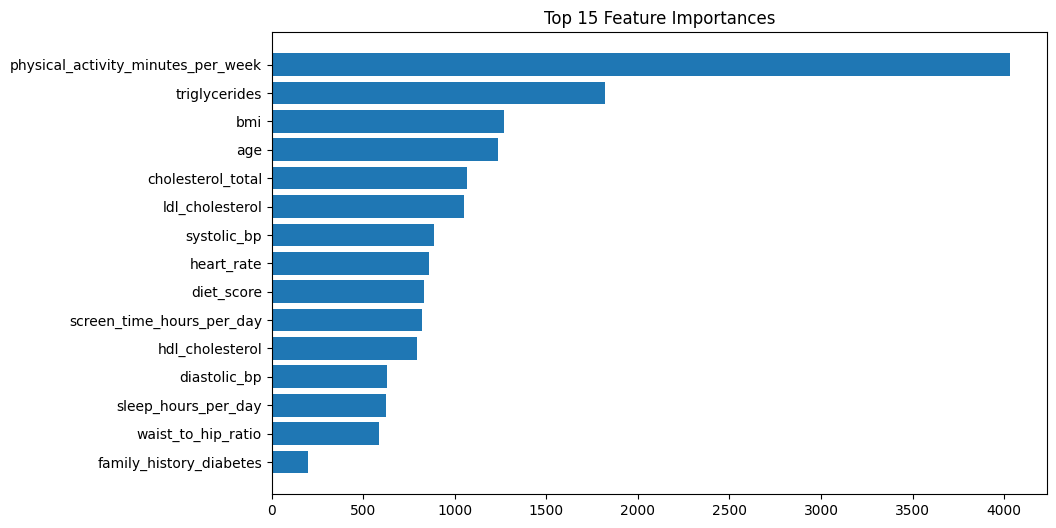

In [4]:
import matplotlib.pyplot as plt

# Get feature names
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_features])

# Feature importance
importances = pipeline.named_steps["model"].feature_importances_

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

print(feat_imp.head(15))

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp.head(15)["feature"], feat_imp.head(15)["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.show()


In [5]:
test_probs = pipeline.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": test_df["id"],
    "diagnosed_diabetes": test_probs
})

submission.to_csv("submission.csv", index=False)
